In [1]:
import math

import pylab
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


def gen_data(N):
    #X.size(): (N,1)
    X = np.random.randn(N, 1)
    w1 = 2.
    b1 = 8.
    sigma1 = 1e1  # ground truth
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, 1)
    w2 = 3
    b2 = 3.
    sigma2 = 1e0  # ground truth
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, 1)
    return X, Y1, Y2


class TrainData(Dataset):

    def __init__(self, feature_num, X, Y1, Y2):

        self.feature_num = feature_num

        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y1 = torch.tensor(Y1, dtype=torch.float32)
        self.Y2 = torch.tensor(Y2, dtype=torch.float32)

    def __len__(self):
        return self.feature_num

    def __getitem__(self, idx):
        return self.X[idx,:], self.Y1[idx,:], self.Y2[idx,:]


class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num, model):
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, input, targets):

        outputs = self.model(input)

        precision1 = torch.exp(-self.log_vars[0])
        loss = torch.sum(precision1 * (targets[0] - outputs[0]) ** 2. + self.log_vars[0], -1)

        precision2 = torch.exp(-self.log_vars[1])
        loss += torch.sum(precision2 * (targets[1] - outputs[1]) ** 2. + self.log_vars[1], -1)

        loss = torch.mean(loss)

        return loss, self.log_vars.data.tolist()


class MTLModel(torch.nn.Module):
    def __init__(self, n_hidden, n_output):
        super(MTLModel, self).__init__()

        self.net1 = nn.Sequential(nn.Linear(1, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_output))
        self.net2 = nn.Sequential(nn.Linear(1, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_output))

    def forward(self, x):
        return [self.net1(x), self.net2(x)]

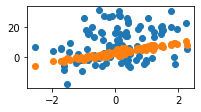

In [2]:
np.random.seed(0)

feature_num = 100
nb_epoch = 2000
batch_size = 20
hidden_dim = 1024

X, Y1, Y2 = gen_data(feature_num)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
pylab.show()

In [3]:
train_data = TrainData(feature_num, X, Y1, Y2)
train_data_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

model = MTLModel(hidden_dim, 1)

mtl = MultiTaskLossWrapper(2, model)
mtl

# https://github.com/keras-team/keras/blob/master/keras/optimizers.py
# k.epsilon() = keras.backend.epsilon()
optimizer = torch.optim.Adam(mtl.parameters(), lr=0.001, eps=1e-07)

loss_list = []
for t in range(nb_epoch):
    cumulative_loss = 0
    
    for X, Y1, Y2 in train_data_loader:

        loss, log_vars = mtl(X, [Y1, Y2])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumulative_loss += loss.item()

    loss_list.append(cumulative_loss/batch_size)

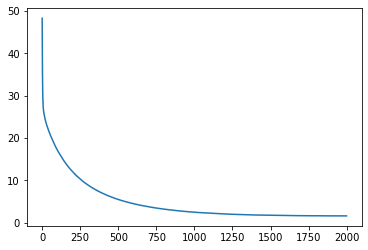

In [4]:
pylab.plot(loss_list)
pylab.show()



In [ ]:
print(log_vars)

In [ ]:
# Found standard deviations (ground truth is 10 and 1):
print([math.exp(log_var) ** 0.5 for log_var in log_vars])

